# Prototipo GNN: Búsqueda de Camino Más Corto
## Inference

### Librerías

In [1]:
# -*- coding: utf-8 -*-
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/GNN')

!pip uninstall -y tensorflow 
!pip install "tensorflow>=1.15,<2"
!pip install graph_nets "dm-sonnet<2" "tensorflow_probability<0.9"
!apt install --allow-change-held-packages libcudnn7=7.4.1.5-1+cuda10.0
#%tensorflow_version 1.x  # For Google Colab only.

Mounted at /content/drive
Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
  Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 110.5 MB 1.3 kB/s 
     |████████████████████████████████| 2.9 MB 51.5 MB/s 
     |████████████████████████████████| 50 kB 6.2 MB/s 
     |████████████████████████████████| 20.1 MB 1.4 MB/s 
     |████████████████████████████████| 3.8 MB 44.2 MB/s 
     |████████████████████████████████| 503 kB 68.8 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=8ff4ec86fbb6525349c1bd37dcb13829030e19c4c33cd120d92cef8ae7cd46a5
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: numpy
    Found existing installation:

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76 kB 3.2 MB/s 
     |████████████████████████████████| 665 kB 11.3 MB/s 
     |████████████████████████████████| 2.5 MB 51.8 MB/s 
  Created wheel for graph-nets: filename=graph_nets-1.1.0-py3-none-any.whl size=91857 sha256=f3cbf19b198c3fd1dcfd7b26de8d51997e649cced90bdede8d791a15a527bfd6
  Stored in directory: /root/.cache/pip/wheels/44/3d/65/f2e8f0a8d0b28bea5f168fc717261a67303d2183a3e450c812
Successfully built graph-nets
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 1.5.0
    Uninstalling cloudpickle-1.5.0:
      Successfully uninstalled cloudpickle-1.5.0
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.16.0
    Uninstalling tensorflow-probability-0.16.0:
      Successfully uninstalled tensorflow-probability-0.16.0
ERROR: pip's dependency resolver does not c

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Debug
import pdb

# Miscelaneas
#%matplotlib widget
import sys
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import collections
import pickle
import time

# Graph nets
from graph_nets import graphs
from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets.demos import models
from graph_nets.graphs import GraphsTuple
import tensorflow as tf

# Py cgr
from py_cgr_lib.py_cgr_lib import Contact
from py_cgr_lib.py_cgr_lib import cgr_dijkstra
from py_cgr_lib.py_cgr_lib import cp_load_from_list

# Helper functions
from gnn_lib.gnn_lib import *


# Inicializacion del generador de numeros aleatorios
SEED = 1
np.random.seed(SEED)
tf.set_random_seed(SEED)
rand = np.random.RandomState(seed=SEED)

# Desactivo la representacion cientifica de numpy
np.set_printoptions(suppress=True)

### Funciones especificas


In [3]:
def Get_Route_from_GNN(raw_graph, output_graph):
  ''' Obtiene la ruta partiendo de la prediccion realiada por GNN
  
  Parameters:
    raw_graph <networkx.MultiDiGraph>: Grafo Raw
    output_graph <graph_nets.DataDict>: Salida del modelo de GNN
    
  Returns:
    path_nodes <list>: Lista de nodos a visitar
    path_edges <list>: Lista de edges a usar
  '''

  # cargo las probabilidad en el grafo
  def softmax_prob_last_dim(x):
    e = np.exp(x)
    return e[:, -1] / np.sum(e, axis=-1)

  edges_probs = softmax_prob_last_dim(output_graph[0]['edges'])

  for i,prob in zip(raw_graph.edges, edges_probs):
    raw_graph.edges[i]['prob']=prob

  # Busco el nodo de inicio
  # Extraigo del grafo los nodos frm y to
  for i in raw_graph.nodes.data():
    if i[1]['frm']:
      node_frm = i[0]
    if i[1]['to']:
      node_to = i[0]

  # Inicio el algoritmo de busqueda
  lastEdgeTime = 0
  path_nodes   = [node_frm]
  path_edges   = []

  while path_nodes[-1] != node_to:
    max_prob=0
    next_node=None
    next_edge=None

    candidates = raw_graph.out_edges(path_nodes[-1], keys=True, data=True)
    if len(candidates)==0:
      raise ValueError("No se pudo encontrar una solucion")
    for i in candidates:
      if (i[3]['end'] > lastEdgeTime):
        if (i[3]['prob'] > max_prob) and not (i[1] in path_nodes):
          lastEdgeTime_tmp = i[3]['start']
          max_prob = i[3]['prob']
          next_node = i[1]
          next_edge = (i[0],i[1],i[2],round(i[3]['prob'],5))

    lastEdgeTime = max(lastEdgeTime, lastEdgeTime_tmp)
    path_nodes.append(next_node)
    path_edges.append(next_edge)

    # Si no se puede encontrar una ruta valida devuelve una ruta parcial con None al final
    if next_edge == None:
      break

  return path_nodes, path_edges


def getArrivalTime(paths_edges, graphs):
  arrivalTimes = []
  # GNN y CGR case
  for i, j in zip(paths_edges, graphs):
    if None in i:
      arrivalTimes.append(None)
    else:
      arrivalTime = 0
      for ii in i:
        arrivalTime = max(arrivalTime, j.edges[ii[0:3]]['start'])
      arrivalTimes.append(arrivalTime)
  
  return arrivalTimes


def Get_Direct_Route(t_inicial, node_A, node_B, FullContactPlan_eval):
  path_edge = None
  arrivalTime = None
  for i in FullContactPlan_eval:
    if (i[2] == node_A) and (i[3] == node_B) and (i[1] > t_inicial):
      path_edge = (node_A, node_B, i[0])
      arrivalTime = i[0]-t_inicial
      if arrivalTime < 0:
        arrivalTime = 0
      break

  return path_edge, arrivalTime

### Load the Model

In [4]:
# Parametros de configuracion del modelo
Path_Model = './Checkpoints/GNN_model_Dataset_Escenario4_04-10-2022_0648-19999'
num_processing_steps_eval = 5

# 0. Reseteo la session de tensorflow
tf.reset_default_graph()
try:
  sess.close()
except NameError:
  pass

# 1. Inicio session de tensorflow y cargo el modelo entrenado
sess = tf.Session()
saver = tf.train.import_meta_graph(Path_Model + ".meta")
saver.restore(sess, Path_Model)

# 2. Recupero los placeholders, operaciones y variables del modelo
tf_graph = tf.get_default_graph()
input_ph = GraphsTuple(nodes    = tf_graph.get_tensor_by_name("input_ph/nodes:0"),
                       edges    = tf_graph.get_tensor_by_name("input_ph/edges:0"),
                       globals  = tf_graph.get_tensor_by_name("input_ph/globals:0"),
                       receivers= tf_graph.get_tensor_by_name("input_ph/receivers:0"),
                       senders  = tf_graph.get_tensor_by_name("input_ph/senders:0"),
                       n_node   = tf_graph.get_tensor_by_name("input_ph/n_node:0"),
                       n_edge   = tf_graph.get_tensor_by_name("input_ph/n_edge:0"))

output_ops_eval = []
for i in range(num_processing_steps_eval):
    if i == 0:
      index_aux=''
    else:
      index_aux='_' + str(i)
    output_ops_eval.append(
        GraphsTuple(nodes    = tf_graph.get_tensor_by_name("EncodeProcessDecode_3/graph_independent{}/node_model/node_output/add:0".format(index_aux)),
                    edges    = tf_graph.get_tensor_by_name("EncodeProcessDecode_3/graph_independent{}/edge_model/edge_output/add:0".format(index_aux)),
                    globals  = tf_graph.get_tensor_by_name("EncodeProcessDecode_3/MLPGraphIndependent_1{}/graph_independent/global_model/sequential/layer_norm/batchnorm/add_1:0".format(index_aux)),
                    receivers= tf_graph.get_tensor_by_name("input_ph/receivers:0"),
                    senders  = tf_graph.get_tensor_by_name("input_ph/senders:0"),
                    n_node   = tf_graph.get_tensor_by_name("input_ph/n_node:0"),
                    n_edge   = tf_graph.get_tensor_by_name("input_ph/n_edge:0")))

## Predicciones

In [5]:
# Parametros de configuracion de la evaluacion
Path_FullContactPlan_eval = "scenarios/GNN_Escenario_4_Test.txt"
TimeWindowLength = 43200*1

# Load the full contact plan
FullContactPlan_eval    = load_contactplan(Path_FullContactPlan_eval)


output_graphs = []
target_graphs = []
ElapsedTimesCGR = []
ElapsedTimesGNN = []
paths_nodes_GNN  = []
paths_edges_GNN  = []
paths_nodes_CGR  = []
paths_edges_CGR  = []
paths_edges_Direct = []
ArrivalTimesDirect = []

# Genero N evaluaciones
for i in range(5000):

    # Fuerzo a que el grafo de ejemplo generado tenga una ruta valida, reintentando en caso contrario
    flag_abort = 0
    target_graph = None
    while (target_graph==None) and (flag_abort<20):
        flag_abort+=1

        # Generamos parametros aleatorios
        t_inicial, t_final, node_A, node_B = generate_rand_param(rand, FullContactPlan_eval, TimeWindowLength, node_B=0)

        # Generamos un subContactPlan y su grafo asociado, partiendo de los parametros aleatorios obtenidos anteriormente
        input_graph, subContactPlan = generate_graph(FullContactPlan_eval, t_inicial, t_final, node_A, node_B)

        # Computo CGR
        target_graph, ElapsedTimeCGR = add_cgr_path(input_graph, subContactPlan)

    if target_graph==None:
      raise ValueError("Graph with invalid path")
    
    # Agrego los feactures a los grafos
    input_graph  = add_features_input(input_graph)
    target_graph = add_features_target(target_graph)

    # Si es la primer muestra, ejecuto dos veces la red neuronal, para precargar el modelo en la memoria
    if i == 0:
      eval_values  = sess.run({"outputs": output_ops_eval}, feed_dict={input_ph: utils_np.networkxs_to_graphs_tuple([input_graph])})
    
    # Paso el grafo por la red neuronal
    ElapsedTimeGNN = time.time()
    eval_values  = sess.run({"outputs": output_ops_eval}, feed_dict={input_ph: utils_np.networkxs_to_graphs_tuple([input_graph])})
    ElapsedTimeGNN = time.time() - ElapsedTimeGNN
    output_graph = utils_np.graphs_tuple_to_data_dicts(eval_values['outputs'][-1])

    # Obtengo ruta predicha con GNN
    path_nodes_GNN, path_edges_GNN = Get_Route_from_GNN(target_graph, output_graph)

    # Obtengo ruta predicha con CGR
    path_nodes_CGR = target_graph.graph['path_nodes']
    path_edges_CGR = target_graph.graph['path_edges']

    # Obtengo ruta predicha con Direct routing
    path_edges_Direct, arrivalTime_Direct = Get_Direct_Route(t_inicial, node_A, node_B, FullContactPlan_eval)
  
    # Append results
    output_graphs.append(output_graph[0])
    target_graphs.append(target_graph)
    ElapsedTimesCGR.append(ElapsedTimeCGR*1000) # Convert to ms
    ElapsedTimesGNN.append(ElapsedTimeGNN*1000) # Convert to ms
    paths_nodes_GNN.append(path_nodes_GNN)
    paths_edges_GNN.append(path_edges_GNN)
    paths_nodes_CGR.append(path_nodes_CGR)
    paths_edges_CGR.append(path_edges_CGR)
    paths_edges_Direct.append(path_edges_Direct)
    ArrivalTimesDirect.append(arrivalTime_Direct)

# Compute the Accuracy
metric_eval, hops_vs_accuracy = compute_accuracy(utils_np.data_dicts_to_graphs_tuple(output_graphs), utils_np.networkxs_to_graphs_tuple(target_graphs))

# Compute Arrival Times
ArrivalTimesGNN = getArrivalTime(paths_edges_GNN, target_graphs)
ArrivalTimesCGR = getArrivalTime(paths_edges_CGR, target_graphs)

# Compute statistical values
ElapsedTimesCGRMin  = min(ElapsedTimesCGR)
ElapsedTimesCGRMax  = max(ElapsedTimesCGR)
ElapsedTimesCGRMean = np.mean(ElapsedTimesCGR)
ElapsedTimesCGRStd  = np.std(ElapsedTimesCGR)
ElapsedTimesGNNMin  = min(ElapsedTimesGNN)
ElapsedTimesGNNMax  = max(ElapsedTimesGNN)
ElapsedTimesGNNMean = np.mean(ElapsedTimesGNN)
ElapsedTimesGNNStd  = np.std(ElapsedTimesGNN)
ElapsedTimesGNN[0]  = ElapsedTimesGNNMean # Elimino el primer valor, demora mucho porque tiene que cargar la red en memoria

ArrivalTimesGNNFilter = list(np.array(ArrivalTimesGNN)[np.array(ArrivalTimesGNN)!=None])
ArrivalTimesCGRMin    = min(ArrivalTimesCGR)
ArrivalTimesCGRMax    = max(ArrivalTimesCGR)
ArrivalTimesCGRMean   = np.mean(ArrivalTimesCGR)
ArrivalTimesGNNMin    = min(ArrivalTimesGNNFilter)
ArrivalTimesGNNMax    = max(ArrivalTimesGNNFilter)
ArrivalTimesGNNMean   = np.mean(ArrivalTimesGNNFilter)
ArrivalTimesDirectMin = min(ArrivalTimesDirect)
ArrivalTimesDirectMax = max(ArrivalTimesDirect)
ArrivalTimesDirectMean= np.mean(ArrivalTimesDirect)


In [6]:
aux = Path_Model.split('_')
DatasetName=aux[2] +'_'+ aux[3]
timestamp=aux[4]+'_'+aux[5].split('-')[0]
# Guardo los raw de los plots
with open('Results/Train_Result_' + DatasetName + '_' + timestamp + '_ElapsedTimesCGR' + '.pickle', 'wb') as file:
  pickle.dump(ElapsedTimesCGR, file, protocol=pickle.HIGHEST_PROTOCOL)

with open('Results/Train_Result_' + DatasetName + '_' + timestamp + '_ElapsedTimesGNN' + '.pickle', 'wb') as file:
  pickle.dump(ElapsedTimesGNN, file, protocol=pickle.HIGHEST_PROTOCOL)

with open('Results/Train_Result_' + DatasetName + '_' + timestamp + '_ArrivalTimesCGR' + '.pickle', 'wb') as file:
  pickle.dump(ArrivalTimesCGR, file, protocol=pickle.HIGHEST_PROTOCOL)

with open('Results/Train_Result_' + DatasetName + '_' + timestamp + '_ArrivalTimesGNN' + '.pickle', 'wb') as file:
  pickle.dump(ArrivalTimesGNN, file, protocol=pickle.HIGHEST_PROTOCOL)

with open('Results/Train_Result_' + DatasetName + '_' + timestamp + '_ArrivalTimesDirect' + '.pickle', 'wb') as file:
  pickle.dump(ArrivalTimesDirect, file, protocol=pickle.HIGHEST_PROTOCOL)



### Plor results

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  https://people.eecs.berkeley.edu/~wkahan/Mindless.pdf
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


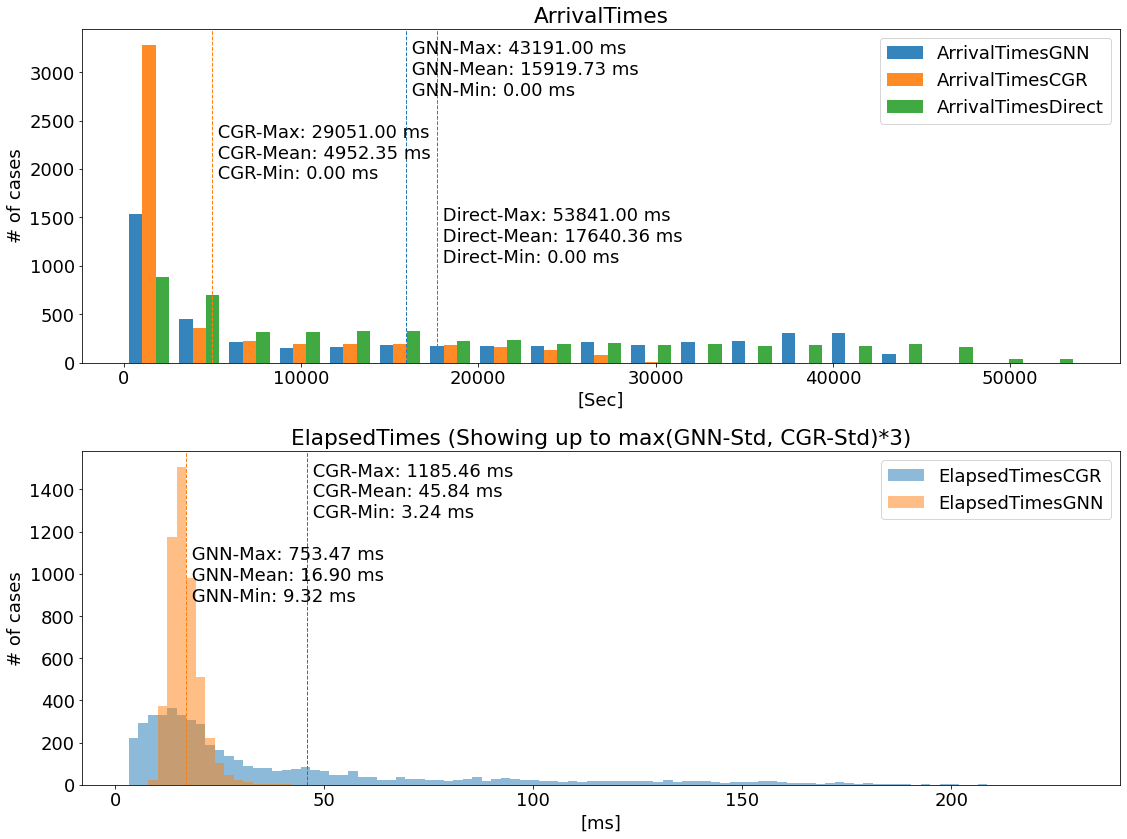

In [7]:
plt.rcParams.update({'font.size': 18})

bins = np.linspace(0, max(ArrivalTimesCGRMax, ArrivalTimesGNNMax, ArrivalTimesDirectMax), 20)

# Figure
fig = plt.figure(1, figsize=(16, 12))
fig.clf()

# Plot 1
ax = fig.add_subplot(2, 1, 1)
ax.hist([ArrivalTimesGNNFilter, ArrivalTimesCGR, ArrivalTimesDirect], bins, alpha=0.9, histtype='bar',
        color=['tab:blue', 'tab:orange', 'tab:green'], label=["ArrivalTimesGNN", "ArrivalTimesCGR", "ArrivalTimesDirect"])

min_ylim, max_ylim = ax.get_ylim()
ax.axvline(ArrivalTimesGNNMean, color='tab:blue', linestyle='dashed', linewidth=1)
ax.text(ArrivalTimesGNNMean, max_ylim*0.8, ' GNN-Max: {:.2f} ms\n GNN-Mean: {:.2f} ms\n GNN-Min: {:.2f} ms'.format(
        ArrivalTimesGNNMax, ArrivalTimesGNNMean, ArrivalTimesGNNMin))
ax.axvline(ArrivalTimesCGRMean, color='tab:orange', linestyle='dashed', linewidth=1)
ax.text(ArrivalTimesCGRMean, max_ylim*0.55, ' CGR-Max: {:.2f} ms\n CGR-Mean: {:.2f} ms\n CGR-Min: {:.2f} ms'.format(
        ArrivalTimesCGRMax, ArrivalTimesCGRMean, ArrivalTimesCGRMin))
ax.axvline(ArrivalTimesDirectMean, color='tab:green', linestyle='dashed', linewidth=1)
ax.text(ArrivalTimesDirectMean, max_ylim*0.3, ' Direct-Max: {:.2f} ms\n Direct-Mean: {:.2f} ms\n Direct-Min: {:.2f} ms'.format(
        ArrivalTimesDirectMax, ArrivalTimesDirectMean, ArrivalTimesDirectMin))

ax.set_title("ArrivalTimes")
ax.set_xlabel("[Sec]")
ax.set_ylabel("# of cases")
ax.legend()

# Plot 2
#ax = fig.add_subplot(4, 1, 2)
#ax.hist(ArrivalTimesCGR, bins, color='tab:orange', alpha=0.5, label="ArrivalTimesCGR")

#min_ylim, max_ylim = ax.get_ylim()
#ax.axvline(ArrivalTimesCGRMean, color='tab:orange', linestyle='dashed', linewidth=1)
#ax.text(ArrivalTimesCGRMean, max_ylim*0.7, ' CGR-Max: {:.2f} ms\n CGR-Mean: {:.2f} ms\n CGR-Min: {:.2f} ms'.format(
#        ArrivalTimesCGRMax, ArrivalTimesCGRMean, ArrivalTimesCGRMin))

#ax.set_title("ArrivalTimes")
#ax.set_xlabel("[Seg]")
#ax.set_ylabel("# de casos")
#ax.legend()

# Plot 3
#ax = fig.add_subplot(4, 1, 3)
#ax.hist(ArrivalTimesDirect, bins, color='tab:green', alpha=0.5, label="ArrivalTimesDirect")

#min_ylim, max_ylim = ax.get_ylim()
#ax.axvline(ArrivalTimesDirectMean, color='tab:green', linestyle='dashed', linewidth=1)
#ax.text(ArrivalTimesDirectMean, max_ylim*0.7, ' Direct-Max: {:.2f} ms\n Direct-Mean: {:.2f} ms\n Direct-Min: {:.2f} ms'.format(
#        ArrivalTimesDirectMax, ArrivalTimesDirectMean, ArrivalTimesDirectMin))

#ax.set_title("ArrivalTimes")
#ax.set_xlabel("[Seg]")
#ax.set_ylabel("# de casos")
#ax.legend()

# # Plot 4: Histograma, Elapsed time (CGR, GNN)
ax = fig.add_subplot(2, 1, 2)

bins = np.linspace(min(ElapsedTimesCGRMin, ElapsedTimesGNNMin), max(ElapsedTimesCGRStd, ElapsedTimesGNNStd)*3, 100)

ax.hist(ElapsedTimesCGR, bins, alpha=0.5, color='tab:blue', label="ElapsedTimesCGR")
ax.hist(ElapsedTimesGNN, bins, alpha=0.5, color='tab:orange', label="ElapsedTimesGNN")

min_ylim, max_ylim = ax.get_ylim()
ax.axvline(ElapsedTimesCGRMean, color='tab:blue', linestyle='dashed', linewidth=1)
ax.text(ElapsedTimesCGRMean, max_ylim*0.8, ' CGR-Max: {:.2f} ms\n CGR-Mean: {:.2f} ms\n CGR-Min: {:.2f} ms'.format(
        ElapsedTimesCGRMax, ElapsedTimesCGRMean, ElapsedTimesCGRMin))

ax.axvline(ElapsedTimesGNNMean, color='tab:orange', linestyle='dashed', linewidth=1)
ax.text(ElapsedTimesGNNMean, max_ylim*0.55, ' GNN-Max: {:.2f} ms\n GNN-Mean: {:.2f} ms\n GNN-Min: {:.2f} ms'.format(
        ElapsedTimesGNNMax, ElapsedTimesGNNMean, ElapsedTimesGNNMin))

ax.set_title("ElapsedTimes (Showing up to max(GNN-Std, CGR-Std)*3)")
ax.set_xlabel("[ms]")
ax.set_ylabel("# of cases")
ax.legend()

plt.tight_layout()

In [8]:
metric_eval

{'accuracy_graph': 0.0,
 'precision_nodes': 0.8275222016872016,
 'recall_nodes': 0.49745468787916286,
 'f1_nodes': 0.5717408621691328,
 'precision_edges': 0.14671685333333334,
 'recall_edges': 0.029488464614161203,
 'f1_edges': 0.043086944103095125}

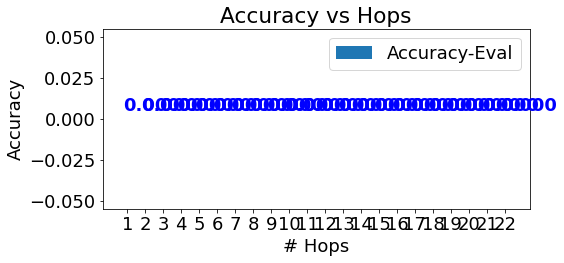

In [9]:
# Figura
fig = plt.figure(1, figsize=(8, 4))
fig.clf()

# 1. Plot: accuracy vs Hops
ax = fig.add_subplot(1, 1, 1)
x_ev = list(hops_vs_accuracy.keys())
y_ev = list(hops_vs_accuracy.values())
ax.bar(range(len(x_ev)), y_ev, tick_label=x_ev, align="center", width=0.6, label="Accuracy-Eval")
ax.set_title("Accuracy vs Hops")
ax.set_xlabel("# Hops")
ax.set_ylabel("Accuracy")
ax.legend()
for x, y in enumerate(y_ev):
  ax.text(x-0.25, y+0.005, "{:.3f}".format(y), color='blue', fontweight='bold')


plt.tight_layout()

In [10]:
# TODO List:
#  - Graficar edges por separado

# Para mejorar:
#  - Normalizar tiempos entre 0 y 1
#  - toquetear parametros de entrenamiento
#  - agregar algun feature
#  - toquetear modelo 